# How to perform PRF photometry on Extra-Galactic Objects


In this tutorial, we will demonstrate a set of new tools introduced in `lightkurve` to perform PRF photometry on extra-galactic objects such as AGN. One of the highlights of our new tools is generating priors for not only the central source that we're trying to create a scene model, but also to estimate a better PSF the user can now also generate priors based on surrounding sources. This is especially useful in cases where crowded fields are present

## Using `.get_prior()`

The function `.get_prior` is an automated way to generate a list of priors of all sources present in a given tpf. The prior returns 2 positional vectors (column, row) alongside with a flux and associated id number for each source. What's unique about `.get_priors()` is that it will also generate a prior for sources that have their PSF wings extend on the TPF. This altogetger will begin eliminating methods of contamination. 

We will initially begin with an isolated AGN to perform PRF photometry and demonstrate a Scene Model with the condition of it being a realively isolated sample

In [304]:
from lightkurve import KeplerTargetPixelFile
tpf = KeplerTargetPixelFile.from_archive(10645722, quarter=16, quality_bitmask='hardest')

   id        ra        dec       pmra    pmdec    mag  
            deg        deg     mas / yr mas / yr  mag  
-------- ---------- ---------- -------- -------- ------
10645722 281.843080  47.937813      0.0      0.0 15.695


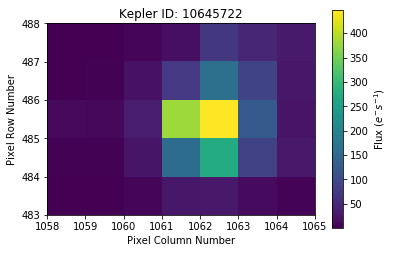

In [305]:
print (tpf.get_sources())
tpf.plot()

As seen in the TPF plot above, the function `.get_sources()` also suggests that there are no other surrounding sources that may be interfering with the central source

In [306]:
# Generate the prior of the tpf 
prior = tpf.get_prior()

Only once source has been identified. Priors will be generated by the TPF


 When applying the function `.get_prior()` depending on each case, it will determine whether the field has identified either only one source or many. 
 
 In the case of a single source (shown in this example), the priors will be generated by the TPF information available. The funciton will return a list of (column, row, max.flux, keplerid)

In [307]:
# Import stuff we need
import matplotlib.pyplot as plt
%matplotlib inline
from lightkurve import prf_photometry as prf_phot
from oktopus import GaussianPrior, UniformPrior
from lightkurve import prf as PRF
import numpy as np

We will now begin to utilize `StarPrior` to assign priors on the source.

In [308]:
Prior = prf_phot.StarPrior(col=GaussianPrior(mean=prior[0], var=2**2),
                                              row=GaussianPrior(mean=prior[1], var=2**2),
                                              flux=UniformPrior(lb=0, ub=prior[2]),
                                              targetid=prior[3])

model_1 = prf_phot.SceneModel(star_priors=[Prior],
                   background_prior=prf_phot.BackgroundPrior(),
                    focus_prior=prf_phot.FocusPrior(scale_col=GaussianPrior(mean=1, var=0.0001),
                                           scale_row=GaussianPrior(mean=1, var=0.0001),
                                           rotation_angle=UniformPrior(lb=-3.1415, ub=3.1415)),
                   motion_prior=prf_phot.MotionPrior(shift_col=GaussianPrior(mean=0., var=0.01),
                                            shift_row=GaussianPrior(mean=0., var=0.01)),
                   prfmodel=prf_phot.KeplerPRF(tpf.channel, tpf.flux.shape[1:], tpf.column, tpf.row))

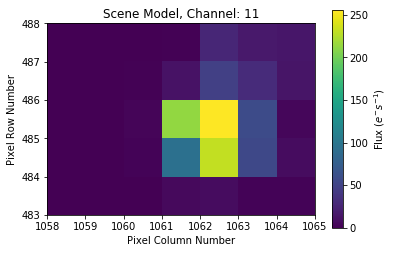

In [309]:
model_1.plot()

We now consider another plausible case, where within the TPF there's an evident secondary source that may be interfering with the PSF of our primary target of interest 

In [116]:
tpf = KeplerTargetPixelFile.from_archive(8946433, quarter=16, quality_bitmask='hardest')

Notice that the central TPF target now is surrounded by 2 other targets (upper left and lower right) with their PSF wings significantly spreading into the region of our main target

   id       ra        dec       pmra    pmdec    mag  
           deg        deg     mas / yr mas / yr  mag  
------- ---------- ---------- -------- -------- ------
8946433 289.395360  45.227104      8.0      6.0 14.293
8946445 289.397640  45.227619      0.0      0.0 17.644


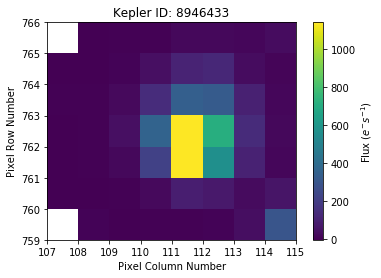

In [117]:
print (tpf.get_sources())
tpf.plot()

In [118]:
prior = tpf.get_prior()

More sources have been identified in the TPF.


In [299]:
lst_prior = []
for i in range (0, len(prior)):
    Prior = prf_phot.StarPrior(col=GaussianPrior(mean=prior[i,0], var=2**2),
                                              row=GaussianPrior(mean=prior[i,1], var=2**2),
                                              flux=UniformPrior(lb=0, ub=prior[i,2]),
                                              targetid=prior[i,3])
    lst_prior.append(Prior)

In [300]:
model_2 = prf_phot.SceneModel(star_priors=lst_prior,
                   background_prior=prf_phot.BackgroundPrior(),
                    focus_prior=prf_phot.FocusPrior(scale_col=GaussianPrior(mean=1, var=0.0001),
                                           scale_row=GaussianPrior(mean=1, var=0.0001),
                                           rotation_angle=UniformPrior(lb=-3.1415, ub=3.1415)),
                   motion_prior=prf_phot.MotionPrior(shift_col=GaussianPrior(mean=0., var=0.01),
                                            shift_row=GaussianPrior(mean=0., var=0.01)),
                   prfmodel=prf_phot.KeplerPRF(tpf.channel, tpf.flux.shape[1:], tpf.column, tpf.row))

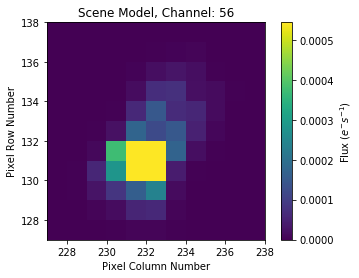

In [301]:
model_2.plot()

### Current errors: 
    > Tranformations betweeen col,row positions and ra, dec from `.get_sources()`
    > Flux callibration seems off

In [234]:
print (prior[:,2])
MAXflux = np.nansum(tpf.flux, axis=(1, 2))

%load_ext autoreload
%autoreload 
print (MAXflux)



[ 20719.90039062    946.21081543]
[ 7298.43359375  7266.52246094  7259.44873047 ...,  7302.75878906
  7324.67285156  7318.72314453]


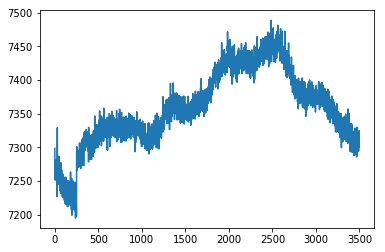

In [253]:
plt.plot(MAXflux)

In [265]:
tpf.get_sources()
%load_ext autoreload
%autoreload 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [267]:
from lightkurve import utils

In [290]:
%load_ext autoreload
%autoreload 

utils.kpmag_to_flux(22)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


1.0804383723712298e-12

In [264]:
eqn

1.1230523475410921e-17